In [337]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [338]:
# set figure key
figure_key = 'Figure4'

In [339]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"OP_meta.csv"),index_col= False)
# temporary drop of A7 due to missing data
metadf = metadf[metadf.ID != 'A7'].reset_index(drop = True)
# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]

In [340]:
#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)

# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


In [341]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [342]:
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)

In [343]:
default_depth = 4
# set heatmap variables
vmin= -5
vmax = 10

#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)
#Condition_figure_name = ['Saline','Acute','Chronic 1 day','W.D. 1 day','Chronic 21 days','W.D. 21 days'] # changed this to betterones
Condition_figure_name = ['Saline','Acute','Chronic','Early WD','Re-exposure','Late WD'] 
Condition_color = ['gray','lime','orange','cyan','blue','purple']
# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

# load and subset dataframes
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,'long_pivoted_heatmap_df_with_normalized_density.csv'),index_col = 0)
pivot_heatmap_df = pivot_heatmap_df[metadf[metadf.Condition.isin(Conditions)]['ID'].values]
merge_df  = pd.read_csv(os.path.join(analysis_resultpath,'Ex_639_Ch2_stitched_long_merge_Annotated_counts_with_leaf_with_density_with_normalized_density.csv'),index_col = 0)
merge_df = merge_df[merge_df.Condition.isin(Conditions)]
# Load the acronyms for plotting
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


remove HB and CBL from the list of ancestores

In [344]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]
#unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB','HB','CBL']

# get a list of idx for the ancestors
ancestor_names = [atlas_df.loc[atlas_df.acronym == f,'name'].values[0] for f in unique_ancestor_curated_acronyms]
ancestor_idxs = [atlas_df.loc[atlas_df.acronym == f,'id'].values[0] for f in unique_ancestor_curated_acronyms]
'''
curated_acronyms = []
ancestor_curated_acronyms = []
for idx,i in enumerate(ancestor_idxs):
    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    curated_acronyms += list(tdf[tdf.Curated_list].acronym)
    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]

# save the new list of acronyms
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(curated_acronyms,handle,)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(ancestor_curated_acronyms,handle,)'''

"\ncurated_acronyms = []\nancestor_curated_acronyms = []\nfor idx,i in enumerate(ancestor_idxs):\n    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    curated_acronyms += list(tdf[tdf.Curated_list].acronym)\n    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]\n\n# save the new list of acronyms\nwith open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(curated_acronyms,handle,)\n\nwith open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(ancestor_curated_acronyms,handle,)"

remove CBL and MB subtree from the atlas file and the merge_df

In [345]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
merge_df = merge_df[merge_df.acronym.isin(sub_atlas_df.acronym.unique())]

set up the metacolumns to be compatible for GLM

In [346]:
# load meta info of the files
metadf['age'] = [(datetime.strptime( pday, '%m/%d/%Y') - datetime.strptime( dob, '%m/%d/%Y')).days for pday,dob in metadf.loc[:,['Date_Perfusion','DOB']].values]
atlasmeta = merge_df.reset_index().loc[merge_df.reset_index().ID =='A1',['id','parent_id','acronym','name','parent_acronym']]

#metaexog = metadf[['Condition','Sex','BW','age','Staining_Batch']]
#metacolumns = ['Saline','Acute_Morphine','Chronic_Morphine','Sex_d','Batch_d']


In [347]:
# change categorical values to dummy chategories dtypes
sex_category = pd.CategoricalDtype(categories=['F', 'M'], ordered=False)
condition_category = pd.CategoricalDtype(categories=Conditions, ordered=True)
batch_category = pd.CategoricalDtype(categories=[1,2,3,4], ordered=False)

merge_df['Sex']             = merge_df['Sex'].astype(sex_category)
merge_df['Condition']       = merge_df['Condition'].astype(condition_category)

merge_df['Staining_Batch']  = merge_df['Staining_Batch'].astype(batch_category)

# create dummy cats
condition_dummies           = pd.get_dummies(merge_df['Condition'])
sex_dummies                 = pd.get_dummies(merge_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
batch_dummies = pd.get_dummies(merge_df['Staining_Batch'])
batch_dummies.columns = [f'Batch_{c}_d' for c in range(4)]

merge_df                    = pd.concat([merge_df,condition_dummies,sex_dummies,batch_dummies],axis =1)

In [348]:
# add flags for conditions
#merge_df = pd.merge(merge_df,metadf[['ID','Acute_flag','Chronic_flag','Spontaneous_flag']],left_on = 'ID',right_on = 'ID')

In [349]:
# calculate effect size raw
raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\
.pivot(columns = 'Condition',index = 'acronym',values = 'density')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3994839575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\


In [350]:
atlas_df.loc[atlas_df.acronym.isin(curated_acronyms),['acronym','name']].to_csv(os.path.join(metapath,'clean_curated_acronyms.csv'),index = False)

Prepare heatmaps into a dictionary format

In [351]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

# Figure 4

## Figure 4B

In [353]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


In [354]:
pannel_key = 'B'

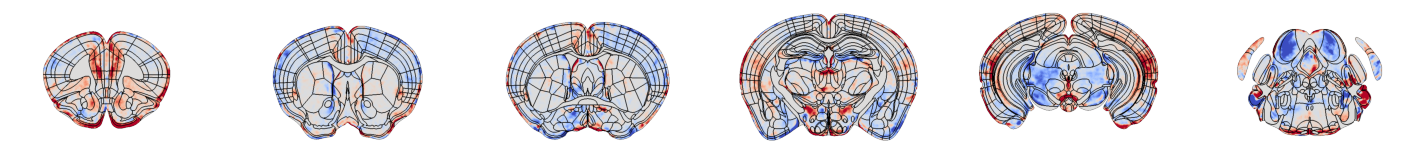

In [355]:
# plot every 10 zplanes
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)

# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]

chronic_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Chronic_Morphine_betas.npy'))
withdrawal_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Withdrawal_Morphine_betas.npy'))

# subtract the withdrawal heatmap from the chronic heatmap
theatmap = chronic_heatmap - withdrawal_heatmap

fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for idx,ax in enumerate(axs):
    formatted_idx = f"{curated_zplanes[idx]:04}" 
    
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)
    trans_img = set_transparency(overlayed_image[curated_zplanes[idx],:,:], (atlas_img==0)[curated_zplanes[idx],:,:])
    #ax.figure(figsize=(10, 10))
    ax.imshow(trans_img[imy_slice, imx_slice,])
    ax.axis('off')
    ax.set_title('')
    #ax.set_ylabel(condition,color = 'black')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 1024)

In [18]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


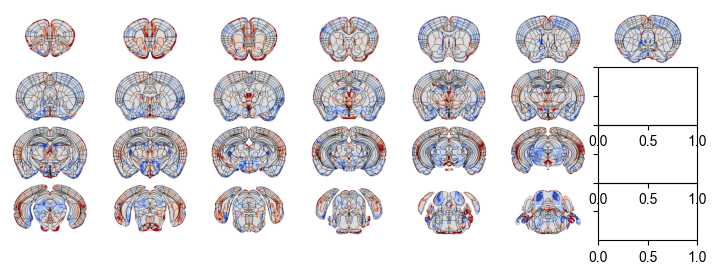

In [19]:
# plot every .3 mm
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)

# pre selected zplanes
curated_zplanes = np.arange(79,229,6) # every .3 mm = 6 zplanes x 50 um 


Chronic_Morphine_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Chronic_Morphine_betas.npy'))
Withdrawal_Morphine_heatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Withdrawal_Morphine_betas.npy'))

# subtract the withdrawal heatmap from the chronic heatmap
theatmap = Chronic_Morphine_heatmap - Withdrawal_Morphine_heatmap
__,overlayed_image = overlap_contour(theatmap,contour_img,\
cmin =  -15, cmax = 15,\
outputpath = None)

fig,axs = plt.subplots(len(curated_zplanes)//6,7,figsize = (3*3,len(curated_zplanes)//7),sharey = True)
fig.subplots_adjust(wspace=0., hspace=0.)

for idx,zplane in enumerate(curated_zplanes):
    if idx < 7:
        rows = 0
        columns = idx%7
    elif idx < 13:
        rows = 1
        columns = (idx + rows-1)%7
    elif idx < 19:
        rows = 2
        columns = (idx + rows-1)%7
    elif idx < 25:
        rows = 3
        columns = (idx + rows-1)%7

    ax = axs[rows,columns]
    formatted_idx = f"{zplane:04}" 
    trans_img = set_transparency(overlayed_image[zplane,:,:], (atlas_img==0)[zplane,:,:])
    ax.imshow(trans_img[imy_slice,imx_slice])
    ax.axis('off')
    ax.set_title('')
    #ax.set_ylabel(condition,color = 'black')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_03mm.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_03mm.pdf'),bbox_inches='tight',dpi = 1024)

## Preparation for clustering

In [43]:
# set conditions to compare
#sub_conditions  = ['Saline','Acute_Morphine']
sub_conditions  = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
sub_IDs         = metadf[metadf.Condition.isin(sub_conditions)].ID.values
sub_merge_df    = merge_df[merge_df.Condition.isin(sub_conditions)]
#sub_pivot_df    = pivot_heatmap_df[sub_IDs]
sub_pivot_df    = merge_df.pivot(columns = 'ID',index= 'acronym',values = 'density')[sub_IDs]

In [44]:
# read the results from the treeFDR f
TreeFDRF_df = pd.read_csv(os.path.join(analysis_resultpath,f'TreeFDRF_pvalue_Figure2_C_glm_stat_df_no_batch.csv'),index_col = False)
# add the cleaned acronym names to the TreeFDR dataframe
TreeFDRF_df = TreeFDRF_df.merge(atlas_df[['acronym','cleaned_acronym']],left_on = 'acronym',right_on = 'acronym')
# get the rejected acronyms and print
rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.acronym.isin(curated_acronyms))&(TreeFDRF_df.rejected == True)].acronym.values
print(len(rejected_acronyms), ' rejected acronyms')
rejected_acronyms


85  rejected acronyms


array(['FrA', 'M1', 'M2', 'S1', 'S2', 'A24a (IL)', 'DI', 'GI', 'AuD',
       'Au1', 'AuV', 'V2L', 'V2M', 'V1', 'A24 (Cg)', 'A32 (PrL)', 'O',
       'AI', 'A29-30 (RS)', 'PtA', 'TeA ', 'PRh', 'Ect', 'AO', 'TT',
       'A25 (DP)', 'CA2', 'CA3', 'DLEnt', 'DIEnt', 'VIEnt', 'MEnt',
       'Post', 'PsS', 'DS', 'VeS', 'STr', 'Cl', 'La', 'CPre', 'CPr',
       'CPi', 'CPc', 'AcbC', 'AcbSh', 'IPAC', 'Tu', 'LS', 'Ce', 'ST',
       'Sc', 'PIL', 'PP', 'MG', 'Po', 'PLi', 'SG', 'AM', 'IAM', 'IAD',
       'IMD', 'PoMn', 'MD', 'Sub', 'PVT', 'RE', 'Rh', 'CM', 'PC', 'PrG',
       'MBO', 'Com', 'VTA', 'PlPAG', 'MA3', 'PrEW', '4Sh', 'Pa4', 'VTg',
       'SNC', 'SPTg', 'IP', 'RLi ', 'CLi', 'DR'], dtype=object)

In [45]:
import umap.umap_
import umap.plot

In [270]:
# subset data to non saline subjects
# the chronic and withdrawal conditions were used for the clustering. 
# Subset the dataframe to only rejected_acronyms that were defined from the TreeBH analysis in Figure 2.

average_key = False
subset_key = True
subset_conditions = ['Chronic_Morphine','Withdrawal_Morphine']

# store the results in a new dataframe
umap_data = sub_pivot_df.loc[rejected_acronyms,metadf[metadf.Condition.isin(subset_conditions)]['ID']]


In [271]:
# scale the data frame using a sklearn package
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
scaler = StandardScaler()

scale_key = True

# scale and store the dataframe again
data = scaler.fit_transform(umap_data.to_numpy().T)
data = pd.DataFrame(data.T, columns = umap_data.columns,index = umap_data.index)
'''teffect_size_df = effect_size_df.set_index('acronym').loc[rejected_acronyms,Conditions[1:]]
scaled_effect_size_df = scaler.fit_transform(teffect_size_df.to_numpy().T)
scaled_effect_size_df = pd.DataFrame(scaled_effect_size_df.T, columns = teffect_size_df.columns,index = teffect_size_df.index)
'''
    

"teffect_size_df = effect_size_df.set_index('acronym').loc[rejected_acronyms,Conditions[1:]]\nscaled_effect_size_df = scaler.fit_transform(teffect_size_df.to_numpy().T)\nscaled_effect_size_df = pd.DataFrame(scaled_effect_size_df.T, columns = teffect_size_df.columns,index = teffect_size_df.index)\n"

<Axes: xlabel='ID', ylabel='acronym'>

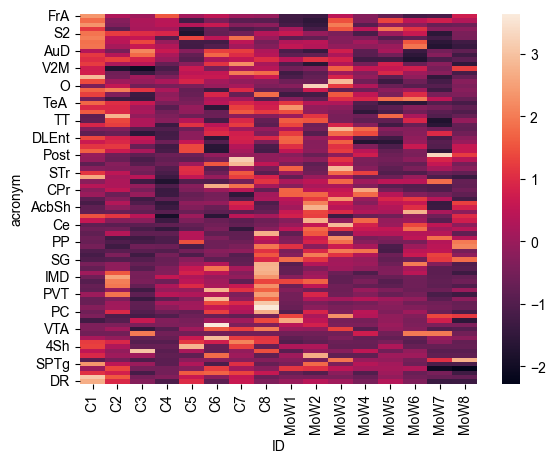

In [272]:
# try plotting the heatamap
sns.heatmap(data)

In [273]:
# create a function to determine variables
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), )
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], )
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2],  s=100)
    plt.title(title, fontsize=18)

In [274]:
# determine the number of neighbors
n_neighbors = 3
# determine the minimum distance
min_dist = 0.2

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


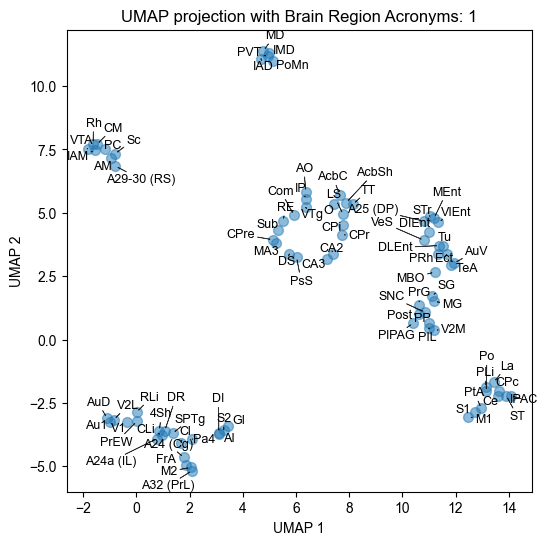

In [275]:
# Create UMAP embedding
mapper = umap.UMAP(n_components = 2,n_neighbors=n_neighbors, min_dist=min_dist,random_state = 45).fit(data)

# Extract the embedding coordinates
embedding = mapper.embedding_

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the points with larger size
sc = ax.scatter(embedding[:, 0], embedding[:, 1], s=50, alpha=0.5)  # Adjust 's' for larger points

texts = []
# Annotate each point with the corresponding acronym
for i, acronym in enumerate(data.index):
    texts.append(ax.text(embedding[i, 0], embedding[i, 1], acronym, fontsize=9, ha='right'))

'''spcific_texts = []
# for specific genes
for i, gene in enumerate(tdf[np.sum(tdf[[condition1,condition2]]>std,axis = 1)>0].index):
    gene_symbol = atlas_df.set_index('acronym').loc[gene,'cleaned_acronym']
    if not gene in interesting_regions:
        continue
    spcific_texts.append(axs.text(
        tdf.loc[gene,condition1],tdf.loc[gene,condition2],
                            gene_symbol, fontsize=12, alpha=0.75,color='black'))    '''

adjust_text(texts,ax = ax, arrowprops=dict(color='black', lw=0.5,alpha = 0.75))

# Show the plot
plt.title(f"UMAP projection with Brain Region Acronyms: {idx}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

## Figure E

Plot the hdbscan linkage tree

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


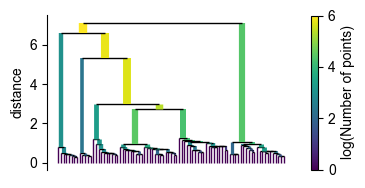

In [276]:
import hdbscan
pannel_key = 'E'
# Assuming you have already fitted your data with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3,)
clusterer.fit(embedding)

# Plot the single linkage tree to confirm the number of clusters
fig,axs = plt.subplots(1,1,figsize= (4,2))
axs = clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
# Save the figure
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}_hdcbscan_tree.tif'), bbox_inches='tight', dpi=216)
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}_hdcbscan_tree.pdf'), bbox_inches='tight', dpi=216)


In [277]:
# Extract the ideal clusters (e.g., 3 clusters)
labels = clusterer.single_linkage_tree_.get_clusters(2, min_cluster_size=3)

# rearrange the labels to match the original order
original_label_order = [2,3,1,0,4,5]
set_labels = [1,2,3,4,5,6]
labels = [set_labels[np.where(np.array(original_label_order) == i)[0][0]] for i in labels]
print(labels)


[6, 3, 6, 3, 6, 6, 6, 6, 6, 6, 4, 6, 4, 6, 6, 6, 5, 6, 1, 3, 4, 4, 4, 5, 5, 4, 5, 5, 4, 4, 4, 4, 4, 5, 5, 4, 4, 6, 3, 5, 5, 5, 3, 5, 5, 3, 4, 5, 3, 3, 1, 4, 4, 4, 3, 3, 4, 1, 1, 2, 2, 2, 2, 5, 2, 5, 1, 1, 1, 4, 4, 5, 1, 4, 5, 6, 6, 6, 5, 4, 6, 5, 6, 6, 6]


In [278]:
# write the results
np.save(os.path.join(analysis_resultpath,f'{figure_key}{pannel_key}_umap_mapper_variables.npy'),mapper)

# write the UMAP embedding
embedding_df = pd.DataFrame(embedding,columns = ['UMAP1', 'UMAP2'],index = data.index)
# add labels to the dataframe and write
embedding_df['label'] = labels
# add results from the tree analysis
embedding_df['rejected'] = [f in rejected_acronyms for f in embedding_df.index]
embedding_df.to_csv(os.path.join(analysis_resultpath,f'{figure_key}{pannel_key}_umap_embedding.csv'),index = True)

In [279]:
# read results umap
mapper_variables =  np.load(os.path.join(analysis_resultpath,f'{figure_key}{pannel_key}_umap_mapper_variables.npy'),allow_pickle=True)
embedding_df = pd.read_csv(os.path.join(analysis_resultpath,f'{figure_key}{pannel_key}_umap_embedding.csv'),index_col = 0)

## Figure C

In [298]:
pannel_key = 'C'

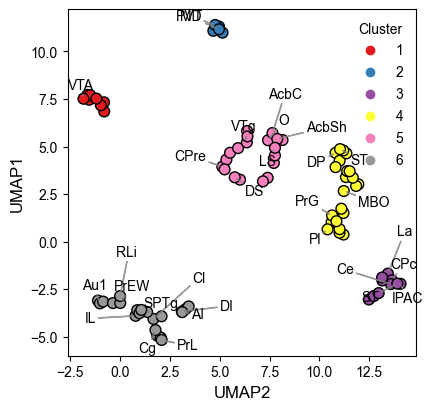

In [299]:
clustered = (embedding_df['label'] >= 0)
rejected = (embedding_df['rejected'] == True)

fig,axs = plt.subplots(1,1,figsize = (4.5,4.5))
scatter = plt.scatter(embedding[clustered & rejected, 0],
            embedding[clustered & rejected, 1],
            c=embedding_df['label'][clustered & rejected],
            s=60,edgecolor = 'k',
            cmap='Set1');
# Adding a legend for the K-means clusters
axs.legend(*scatter.legend_elements(), title = 'Cluster',)

# plot annotations for specific brain regions that are in our interest
curated_texts = ['VTA','VTg','PT','MD','PVT','AcbC','AcbSh','LS','O','ASt','La',
                 'CPce','CPc','Ce','ST','BL','MBO','DP','Pl','DS','CPre','STr','PrL','DI','AI','IL','Cg','SPTg','Cl'] + \
                    ['A24a (IL)','Au1','RLi ','PrEW','A24 (Cg)','Cl', 'A32 (PrL)',   'VTA', 'AcbC', 'AcbSh','La','IPAC','PrG','Ce', 'ST', ]
curated_texts = np.unique(curated_texts)
texts = []
# Annotate each point with the corresponding acronym
for i, acronym in enumerate(data.index):
    clean_acronym = atlas_df[atlas_df.acronym == acronym].cleaned_acronym.values[0]
    tname = atlas_df[atlas_df.acronym == acronym].name.values[0]
    #print(acronym,tname)
    if not clean_acronym in curated_texts:
        continue
    if acronym in rejected_acronyms:
        texts.append(axs.text(embedding[i, 0], embedding[i, 1], clean_acronym, fontsize=10, ha='right'))


adjust_text(texts,ax = axs, expand=(2, 2),force_text=(0.25,0.25),arrowprops=dict(color='gray', lw=1,alpha = 0.75))
axs.set_ylabel('UMAP1',fontsize = 12)
axs.set_xlabel('UMAP2',fontsize = 12)

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches ='tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches ='tight',dpi = 216)

## Figure D

Plot the average normalized density on top of the umap for each condition

### preparation

In [282]:
# effect size data frame
# this will be using normalized_density, which density values normalized to the mean saline data. 
effect_size_df = merge_df[['acronym','Condition','normalized_density']].groupby(['acronym','Condition']).mean().reset_index().pivot(index = 'acronym',columns = 'Condition',values = 'normalized_density').reset_index()
teffect_size_df = effect_size_df.set_index('acronym').loc[rejected_acronyms,Conditions[1:]]
scaled_effect_size_df = scaler.fit_transform(teffect_size_df.to_numpy().T)
scaled_effect_size_df = pd.DataFrame(scaled_effect_size_df.T, columns = teffect_size_df.columns,index = teffect_size_df.index).reset_index()


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\324440647.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  effect_size_df = merge_df[['acronym','Condition','normalized_density']].groupby(['acronym','Condition']).mean().reset_index().pivot(index = 'acronym',columns = 'Condition',values = 'normalized_density').reset_index()


### Plot

In [283]:
pannel_key = 'D'

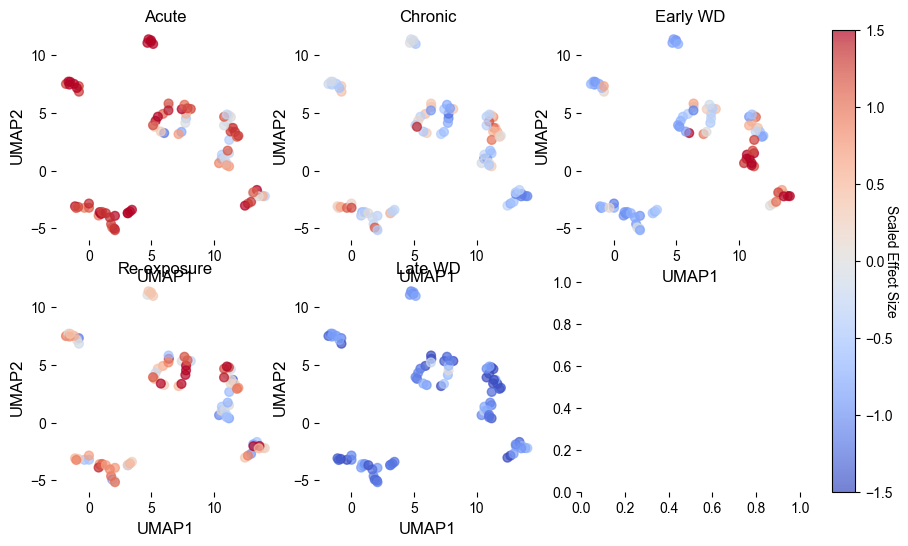

In [284]:
vmin = -1.5
vmax = 1.5
fig,axs = plt.subplots(2,3,figsize=(len(Conditions[1:])*0.7*3, 3*2),)


for cidx, Condition in enumerate(Conditions[1:]):
    ordered_acronym = effect_size_df.set_index('acronym').loc[rejected_acronyms, :].sort_values(by=Condition).index
    ax = axs[(cidx//3),(cidx%3)]
    # Plotting the UMAP embedding with K-means clusters
    scatter = ax.scatter(embedding_df.loc[ordered_acronym,'UMAP1'], embedding_df.loc[ordered_acronym,'UMAP2'],
                         c=scaled_effect_size_df.set_index('acronym').loc[ordered_acronym, Condition], s=40,
                         #c=data.loc[rejected_acronyms, Condition], s=100,
                          alpha=0.7, vmin=vmin, vmax=vmax,cmap = 'coolwarm')

    # Adding a color bar for the effect sizes
    if cidx == len(scaled_effect_size_df.columns[[1,4]])-1:
        colorbar = plt.colorbar(scatter, ax=axs, fraction=0.046, pad=0.04)
        colorbar.set_label('Scaled Effect Size', rotation=-90)

    # Annotating the points with brain region names
    #texts = []
    #for i, brain_region in enumerate(embedding_df.index):
    #    texts.append(ax.text(embedding_df['UMAP1'][i], embedding_df['UMAP2'][i],
    #                         brain_region, fontsize=10, alpha=0.75))


    fCondition = Condition_figure_name[cidx+1].replace("_", ' ')
    ax.set_title(f'{fCondition}')
    ax.set_xlabel('UMAP1',fontsize = 12)
    ax.set_ylabel('UMAP2',fontsize = 12)
# remove all the spines
for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# Save the figure
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}.tif'), bbox_inches='tight', dpi=216)
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}.pdf'), bbox_inches='tight', dpi=216)


## Figure F

In [285]:
pannel_key = 'F'

In [286]:
# add label info to the data frame
data = data.join(embedding_df)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_Chronic_Morphine vs. 2_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:6.427e-06 t=4.840e+00
1_Chronic_Morphine vs. 1_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.088e-03 t=2.851e+00
3_Chronic_Morphine vs. 3_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.525e-15 t=-8.781e+00
4_Chronic_Morphine vs. 4_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:6.411e-02 t=-1.857e+00
5_Chronic_Morphine vs. 5_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.479e-01 t=-1.158e+00
6_Chronic_Morphine vs. 6_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.092

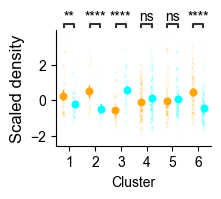

In [287]:

# create a stacked version of the heatmap dataframe
stack_data = data.reset_index().set_index(['acronym','label','UMAP1','UMAP2','rejected']).stack().reset_index().rename(columns = {'level_5':'ID',0:'normalized_density'})
stack_data = stack_data.merge(metadf[['ID','Condition']],left_on = 'ID',right_on = 'ID')

fig,axs = plt.subplots(1,1,figsize= (2,1.5))

sns.stripplot(data = stack_data[stack_data.Condition.isin(['Chronic_Morphine','Withdrawal_Morphine'])],
              hue = 'Condition',y = 'normalized_density',x = 'label',dodge = True,order = set_labels,
        hue_order = Conditions[2:4],ax = axs,palette = Condition_color[2:4],alpha = 0.2,size = 1)
sns.pointplot(data = stack_data[stack_data.Condition.isin(['Chronic_Morphine','Withdrawal_Morphine'])],
              hue = 'Condition',y = 'normalized_density',x = 'label',order = set_labels,
              dodge = .6-0.6/4,errorbar = ("ci",95),\
        hue_order = Conditions[2:4],ax = axs,palette = Condition_color[2:4],
markers="o", markersize=5, linestyle="none",linewidth = 1)  

sns.despine()
#axs.set_xticklabels([str(idx + 1) for idx in range(4)])
axs.set_xlabel('Cluster')
# remove legend
axs.get_legend().remove()
axs.set_ylabel('Scaled density',fontsize = 12)
from statannotations.Annotator import Annotator
pairs = [((c,"Chronic_Morphine"),(c,"Withdrawal_Morphine")) for c in set_labels]

annotator = Annotator(axs, pairs, data=stack_data[stack_data.Condition.isin(['Chronic_Morphine','Withdrawal_Morphine'])],
                     y='normalized_density', x='label',order = set_labels,hue = 'Condition',hue_order = ['Chronic_Morphine','Withdrawal_Morphine'])
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight')


## Figure G

In [288]:
pannel_key = 'G'

In [289]:
# format the data so it can be plotted
sub_merge_df    = merge_df[merge_df.Condition.isin(sub_conditions)]
sub_merge_df = sub_merge_df.merge(data.stack().reset_index(drop = False).rename(columns = {'level_1':'ID',0:'scaled_density'}),
left_on = ['acronym','ID'],
right_on = ['acronym','ID'])
sub_merge_df.Condition = sub_merge_df.Condition.astype('str')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AcbSh_Chronic_Morphine vs. AcbSh_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:3.878e-02 (ns) t=-2.280e+00
La_Chronic_Morphine vs. La_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.406e-02 (ns) t=-2.529e+00
IPAC_Chronic_Morphine vs. IPAC_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:3.407e-04 t=-4.701e+00
PrG_Chronic_Morphine vs. PrG_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:3.065e-04 t=-4.757e+00
Ce_Chronic_Morphine vs. Ce_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.029e-03 t=-4.126e+00
ST_Chronic_Morphine vs. ST_Withdrawal_Morphine: t-test independent samples with Benjam

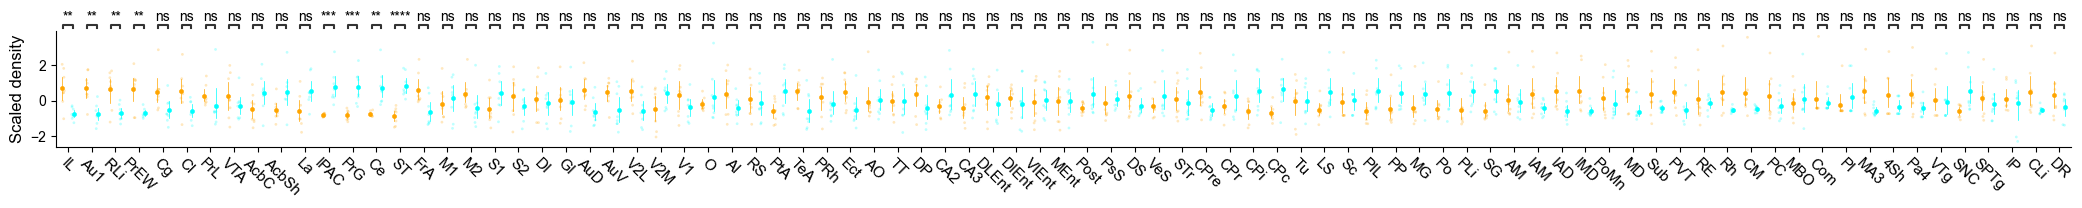

In [290]:
from statannotations.Annotator import Annotator

# create a barplot with a swarmplot overlapped
sorted_acronyms = ['A24a (IL)','Au1','RLi ','PrEW','A24 (Cg)','Cl', 'A32 (PrL)',   'VTA', 'AcbC', 'AcbSh',
       'La','IPAC','PrG','Ce', 'ST', ]
non_sorted_acronyms = [f for f in rejected_acronyms if f not in sorted_acronyms]
pairs = [((c,"Chronic_Morphine"),(c,"Withdrawal_Morphine")) for c in sorted_acronyms + non_sorted_acronyms]

sub_conditions = ['Chronic_Morphine','Withdrawal_Morphine']

sorted_cleaned_acronyms = atlas_df.set_index('acronym').loc[sorted_acronyms + non_sorted_acronyms,'cleaned_acronym'].values
tdata = sub_merge_df[(sub_merge_df.Condition.isin(sub_conditions))&(sub_merge_df.acronym.isin(sorted_acronyms + non_sorted_acronyms))]
tdata.scaled_density = tdata.scaled_density.astype('float64')
fig,axs = plt.subplots(1,1,figsize = (len(sorted_acronyms + non_sorted_acronyms)//3.2,1.5))

sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
sns.stripplot(data = tdata,
            hue = 'Condition',y = 'scaled_density',x = 'acronym',dodge = True,
            order = sorted_acronyms + non_sorted_acronyms,\
        hue_order = Conditions[2:4],ax = axs,palette = Condition_color[2:4],alpha = 0.25,size = 2)
sns.pointplot(tdata,
            hue = 'Condition',y = 'scaled_density',x = 'acronym',order = sorted_acronyms + non_sorted_acronyms,
            dodge = .5-.5/len(sorted_acronyms + non_sorted_acronyms),\
        hue_order = Conditions[2:4],ax = axs,palette = Condition_color[2:4],
markers="o", markersize=3, linestyle="none",linewidth = 0.5)  
sns.despine()
axs.set_xticks(range(len(sorted_cleaned_acronyms)))
axs.set_xticklabels(sorted_cleaned_acronyms,fontsize = 11,rotation = -45)
# remove legend
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel('Scaled density',fontsize = 12)


pairs = [((c,"Chronic_Morphine"),(c,"Withdrawal_Morphine")) for c in sorted_acronyms + non_sorted_acronyms]

annotator = Annotator(axs, pairs, data=tdata,
                     y='scaled_density', x='acronym',hue = 'Condition',
                     hue_order = Conditions[2:4],order = sorted_acronyms + non_sorted_acronyms)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight')



## Figure E

In [291]:
pannel_key = 'E'

In [292]:
# calculate the delta Chronic and Withdrawal effect size
delta_effect_size_df = (effect_size_df.set_index('acronym')['Chronic_Morphine'] - effect_size_df.set_index('acronym')['Withdrawal_Morphine']).\
    reset_index().rename(columns = {0:'dcw'}).set_index('acronym')\
        .join(atlas_df.set_index('acronym')[['cleaned_acronym']]).sort_values(by = 'dcw',ascending = False)
# add it to the data frame
data = delta_effect_size_df.loc[rejected_acronyms,:].join(data)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\2907910169.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ytick_labels = [sorted_data['label'][index] for index in sorted(indexes)[::-1]]


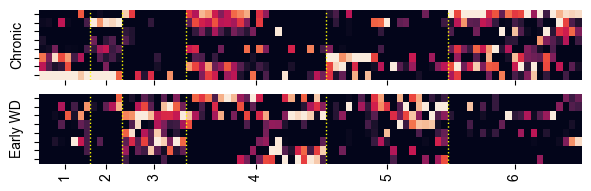

In [296]:
sorted_data = data.sort_values(by = 'label')
sorted_acronyms = sorted_data.sort_values(by = ['label','dcw'],ascending = [True,False]).index
fig,axs = plt.subplots(len(sub_conditions),1, figsize = (7,len(sub_conditions)*1.0),sharex = True)

# calculate variables to plot the heatmatp
labels,indexes = np.unique(sorted_data['label'], return_index=True,)
ytick_labels = [sorted_data['label'][index] for index in sorted(indexes)[::-1]]


counts = [len(np.where(np.array(sorted_data['label']) == ylabel)[0]) for ylabel in ytick_labels][::-1]

borders = [0] + list(np.cumsum(counts))

x = np.array(borders)
yticks = (x[1:] + x[:-1]) / 2

for idx,condition in enumerate(sub_conditions):
    
    subjects = metadf[(metadf.Condition == condition) & (metadf.fname)].ID.values
    if idx == len(Conditions)-2:
        cbar_ax = fig.add_axes([axs[len(Conditions)-2].get_position().x1+0.01,
                                axs[len(Conditions)-2].get_position().y0+0.2,0.05,0.5])
        sns.heatmap(data = sorted_data.loc[sorted_acronyms,subjects].T,cbar_ax = cbar_ax
        ,ax = axs[idx],vmin = -0., vmax = 2)
        cbar_ax.set_ylabel('Scaled density', rotation=270, labelpad=10,fontsize = 10)
    else:
        sns.heatmap(data = sorted_data.loc[sorted_acronyms,subjects].T,cbar = False
        ,ax = axs[idx],vmin =-0., vmax = 2)
    axs[idx].set_xticks(yticks)
    axs[idx].set_xticklabels(ytick_labels[::-1])
    axs[idx].set_xlabel('')
    [axs[idx].axvline(border,color = 'yellow',lw = 1,ls = ':') for border in borders[1:-1]]
    axs[idx].set_yticks(np.array(range(len(subjects))) + 0.5)
    axs[idx].set_yticklabels([],rotation = 0) 
    axs[idx].set_ylabel(Condition_figure_name[2:4][idx])
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_clustered_scaled_heatmap.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_clustered_scaled_heatmap.pdf'),bbox_inches = 'tight')


# Figure 4-supplemental figure 1

In [311]:
figure_key = 'Figure4-supplemental figure 1'
pannel_key = 'A'

In [312]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

In [316]:
# transfer labels to sub_merge_df
# format the data so it can be plotted
sub_merge_df    = merge_df[merge_df.Condition.isin(sub_conditions)]
sub_merge_df = sub_merge_df.merge(data.stack().reset_index(drop = False).rename(columns = {'level_1':'ID',0:'scaled_density'}),
left_on = ['acronym','ID'],
right_on = ['acronym','ID'])
sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
sub_merge_df = sub_merge_df.reset_index().merge(embedding_df.reset_index(),left_on = 'acronym',right_on = 'acronym')

In [317]:
# create a barplot with a swarmplot overlapped
condition1 = 'Saline'
sub_effect_size_df = sub_merge_df.loc[(sub_merge_df.acronym.isin(curated_acronyms)) & (sub_merge_df.Condition.isin(sub_conditions)),\
                 ['acronym','Condition','normalized_density']].groupby(['acronym','Condition']).mean().reset_index().\
                    pivot(columns = 'Condition',index = 'acronym',values = 'normalized_density')
delta_sub_effect_size_df = (sub_effect_size_df['Chronic_Morphine'] - sub_effect_size_df['Withdrawal_Morphine']).\
    reset_index().rename(columns = {0:'dcw'}).set_index('acronym')\
        .join(atlas_df.set_index('acronym')[['cleaned_acronym']]).sort_values(by = 'dcw',ascending = False)
sorted_acronyms_list = []
sorted_cleaned_acronyms_list = []
nregions_list = []
for tlabel in labels:
    #print(tlabel)
    tacronyms = sub_merge_df[(sub_merge_df.label == tlabel)&(sub_merge_df.Condition.isin(Conditions[1:]))].acronym.unique()
    nregions = len(tacronyms)
    #a = delta_sub_effect_size_df.set_index('acronym').loc[tacronyms,'Chronic_Morphine']- effect_size_df.set_index('acronym').loc[tacronyms,'Withdrawal_Morphine']
    sorted_acronyms = delta_sub_effect_size_df.loc[tacronyms,'dcw'].sort_values(ascending= False).index
    sorted_cleaned_acronyms = atlas_df.set_index('acronym').loc[sorted_acronyms,'cleaned_acronym'].values
    sorted_cleaned_acronyms_list += list(sorted_cleaned_acronyms)
    sorted_acronyms_list += list(sorted_acronyms)
    nregions_list += [nregions]


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3867497416.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IAD_Chronic_Morphine vs. IAD_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.106e-02 (ns) t=2.598e+00
MD_Chronic_Morphine vs. MD_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.313e-02 (ns) t=2.839e+00
PVT_Chronic_Morphine vs. PVT_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:3.628e-02 (ns) t=2.315e+00
PoMn_Chronic_Morphine vs. PoMn_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.956e-01 t=5.431e-01
M1_Chronic_Morphine vs. M1_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:5.834e-01 t=-5.614e-01
S1_Chronic_Morphine vs. S1_Withdrawal_Morphine: t-test independent samples with Benjamini

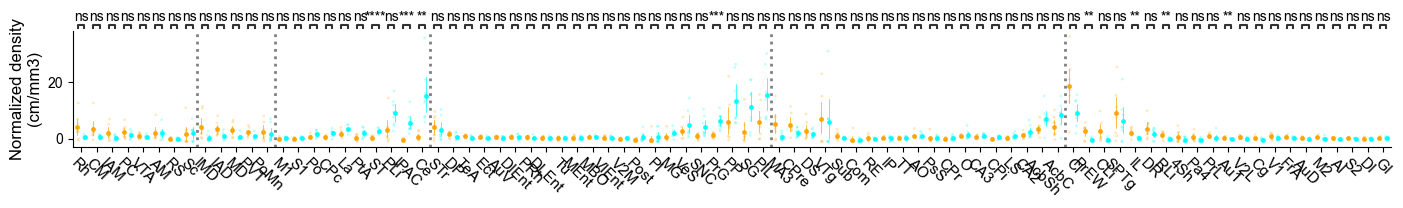

In [318]:

fig,axs = plt.subplots(1,1,figsize = (len(sorted_acronyms_list)//5,1.5))

sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin(sub_conditions))],
            hue = 'Condition',y = 'normalized_density',x = 'acronym',dodge = True,
            order = sorted_acronyms_list,\
        hue_order = Conditions[2:4],ax = axs,palette = Condition_color[2:4],alpha = 0.25,size = 2)
sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin(sub_conditions))],
            hue = 'Condition',y = 'normalized_density',x = 'acronym',order = sorted_acronyms_list,
            dodge = .5-.5/len(sorted_acronyms_list),\
        hue_order = Conditions[2:4],ax = axs,palette = Condition_color[2:4],
markers="o", markersize=3, linestyle="none",linewidth = 0.5)  
sns.despine()
axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)
# remove legend
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel('Normalized density\n(cm/mm3)',fontsize = 12)
# add a horizontal line to separate the clusters
borders = [0] + list(np.cumsum(nregions_list))
[axs.axvline(border - 0.5,color = 'gray',lw = 2,ls = ':') for border in borders[1:-1]]


pairs = [((c,"Chronic_Morphine"),(c,"Withdrawal_Morphine")) for c in sorted_acronyms_list]

annotator = Annotator(axs, pairs, data=tdata,
                     y='scaled_density', x='acronym',hue = 'Condition',
                     hue_order = Conditions[2:4],order = sorted_acronyms_list)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()


fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight')



# Figure 4-supplemental figure 2

In [319]:
figure_key = 'Figure4-supplemental figure 2'
pannel_key = 'A'

In [320]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

In [332]:
sub_merge_df.Condition.unique()

array(['Chronic_Morphine', 'Withdrawal_Morphine'], dtype=object)

In [333]:
# transfer labels to sub_merge_df
# format the data so it can be plotted
sub_merge_df    = merge_df[merge_df.Condition.isin(Conditions)]
sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
sub_merge_df = sub_merge_df.reset_index().merge(embedding_df.reset_index(),left_on = 'acronym',right_on = 'acronym')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IAD_Acute_Morphine vs. IAD_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:1.514e-04 t=5.136e+00
MD_Acute_Morphine vs. MD_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:1.281e-04 t=5.227e+00
PVT_Acute_Morphine vs. PVT_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:7.811e-06 t=6.860e+00
PoMn_Acute_Morphine vs. PoMn_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:7.639e-03 t=3.113e+00
M1_Acute_Morphine vs. M1_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:1.030e-01 t=1.744e+00
S1_Acute_Morphine vs. S1_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:9.908e-02 t=1.767e+00
Po_Acute_Morphine vs. Po_Saline: t-test independent samp

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IAD_Chronic_Morphine vs. IAD_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:2.913e-03 t=3.597e+00
MD_Chronic_Morphine vs. MD_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:2.839e-03 t=3.610e+00
PVT_Chronic_Morphine vs. PVT_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:2.253e-03 t=3.727e+00
PoMn_Chronic_Morphine vs. PoMn_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:8.247e-02 t=1.870e+00
M1_Chronic_Morphine vs. M1_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:7.793e-01 t=-2.857e-01
S1_Chronic_Morphine vs. S1_Saline: t-test independent samples with Benjamini-Hochberg correction, P_val:8.970e-01 t=-1.319e-01
Po_Chronic_Morphine vs. Po_Saline: t-test 

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IAD_Saline vs. IAD_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.592e-01 t=-1.487e+00
MD_Saline vs. MD_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.899e-01 t=-1.378e+00
PVT_Saline vs. PVT_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:8.129e-02 t=-1.879e+00
PoMn_Saline vs. PoMn_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:2.459e-01 t=-1.211e+00
M1_Saline vs. M1_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:7.893e-01 t=-2.724e-01
S1_Saline vs. S1_Withdrawal_Morphine: t-test independent samples with Benjamini-Hochberg correction, P_val:1.457e-01 t=-1.541e+00
Po_Saline vs. Po_Wit

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occur

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IAD_Saline vs. IAD_Chronic_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:2.332e-03 t=-3.845e+00
MD_Saline vs. MD_Chronic_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:4.887e-04 t=-4.730e+00
PVT_Saline vs. PVT_Chronic_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:6.871e-04 t=-4.532e+00
PoMn_Saline vs. PoMn_Chronic_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:1.401e-02 t=-2.873e+00
M1_Saline vs. M1_Chronic_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:4.368e-01 t=-8.044e-01
S1_Saline vs. S1_Chronic_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:7.633e-02 t=-1.939e+00
Po_Saline vs. Po_Chr

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_6328\3971105264.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occur

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IAD_Saline vs. IAD_Withdrawal_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:4.402e-01 t=-7.983e-01
MD_Saline vs. MD_Withdrawal_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:6.811e-01 t=-4.212e-01
PVT_Saline vs. PVT_Withdrawal_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:4.844e-01 t=-7.216e-01
PoMn_Saline vs. PoMn_Withdrawal_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:4.135e-01 t=-8.472e-01
M1_Saline vs. M1_Withdrawal_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:1.103e-02 (ns) t=3.002e+00
S1_Saline vs. S1_Withdrawal_Morphine_21: t-test independent samples with Benjamini-Hochberg correction, P_val:9.006e-02 t=1.844e+00

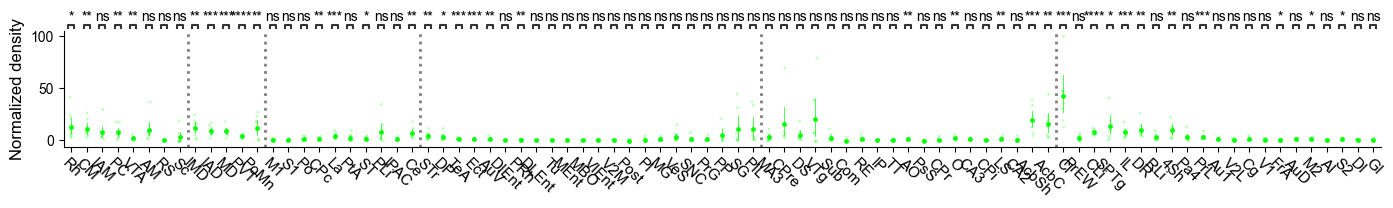

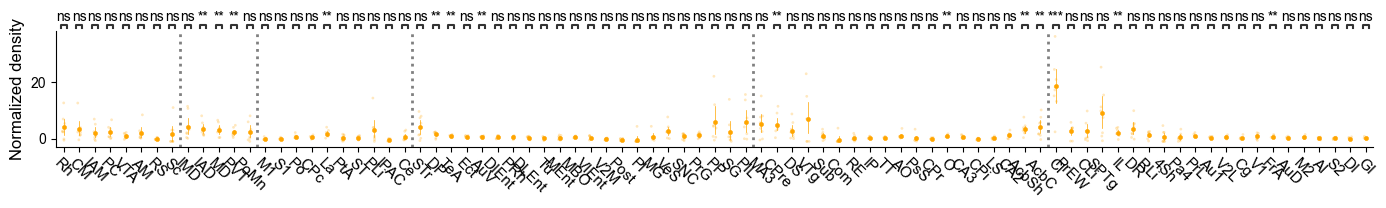

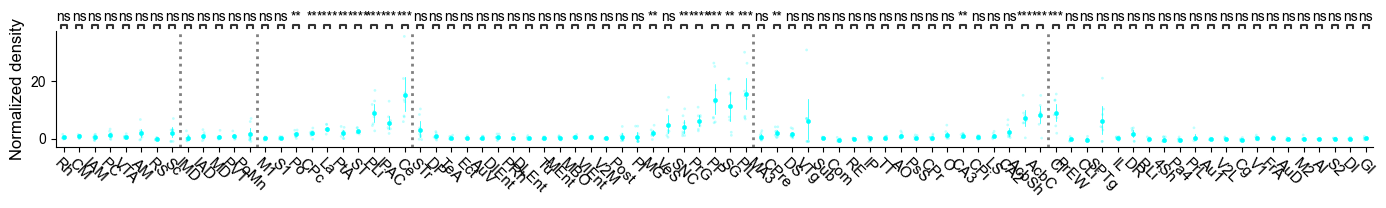

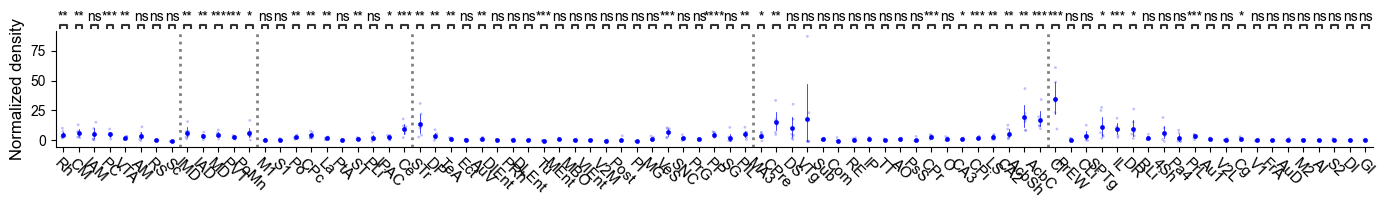

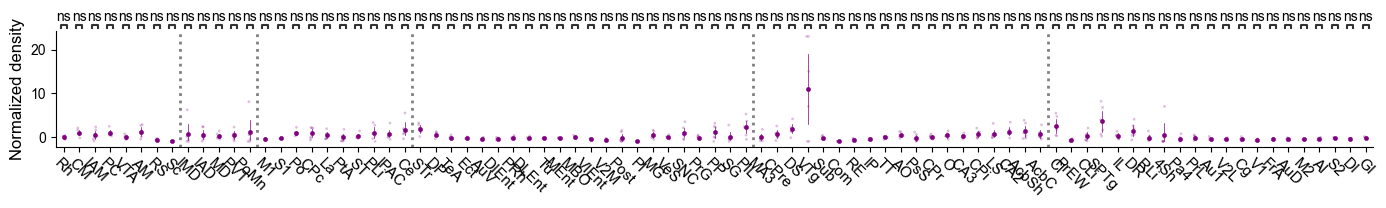

In [336]:
condition1 = 'Saline'
for cidx,condition2 in enumerate(Conditions):
    if condition2 == 'Saline':
        continue
    fig,axs = plt.subplots(1,1,figsize = (len(sorted_acronyms_list)//5,1.5))

    sub_merge_df.Condition = sub_merge_df.Condition.astype('str')
    sns.stripplot(data = sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
                hue = 'Condition',y = 'normalized_density',x = 'acronym',
                order = sorted_acronyms_list,\
                hue_order = [condition2],ax = axs,\
                palette = np.array(Condition_color)[[cidx]],alpha = 0.25,size = 2)
    sns.pointplot(sub_merge_df[(sub_merge_df.Condition.isin([condition2]))],
                hue = 'Condition',y = 'normalized_density',x = 'acronym',order = sorted_acronyms_list,
            hue_order = [condition2],ax = axs,palette = np.array(Condition_color)[[cidx]],
    markers="o", markersize=3, linestyle="none",linewidth = 0.5)  
    sns.despine()
    axs.set_xticklabels(sorted_cleaned_acronyms_list,fontsize = 11,rotation = -45)
    # remove legend
    axs.get_legend().remove()
    axs.set_xlabel('')
    axs.set_ylabel('Normalized density',fontsize = 12)
    # add a horizontal line to separate the clusters
    borders = [0] + list(np.cumsum(nregions_list))
    [axs.axvline(border - 0.5,color = 'gray',lw = 2,ls = ':') for border in borders[1:-1]]

    
    from statannotations.Annotator import Annotator
    pairs = [((c,condition1),(c,condition2)) for c in sorted_acronyms_list]

    annotator = Annotator(axs, pairs, data = sub_merge_df[(sub_merge_df.Condition.isin([condition1,condition2]))],
                hue = 'Condition',y = 'normalized_density',x = 'acronym',
                order = sorted_acronyms_list)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
    annotator.configure(comparisons_correction="BH", correction_format="replace")
    annotator.apply_and_annotate()


    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition2}.png'),bbox_inches = 'tight',dpi = 216)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition2}.pdf'),bbox_inches = 'tight')

